In [110]:
import torch
from torch.utils.data import Dataset, DataLoader
import scipy.io.wavfile as wav
import os
import pandas as pd
import matplotlib.pyplot as plt
import torchaudio
import glob
import math
import torch.nn as nn
import numpy as np
from bisect import bisect_left
import scipy as sp
import h5py
from scipy.io import wavfile
from glob import glob

import sys
import importlib
import json

In [111]:

dataset_path = "../data/reference_data/tdoa_20201016/data/"
experiment = "music_0014"


n_audio_files = len(glob(os.path.join(dataset_path,experiment,"*.wav")))

sounds = []
for i in range(n_audio_files):
    fs, temp = wavfile.read(os.path.join(dataset_path,experiment,"Track " + str(i+1) + ".wav"))
    sounds.append(temp)
sounds = np.stack(sounds)

#read gt
df = pd.read_csv(os.path.join(dataset_path, experiment, "gt_positions.csv")) # Note time-column = 0 when audio-recordings started

dims = ["x","y","z"]
time = df["time"]
senders = df[["speaker" + "_" +dim for dim in dims]].to_numpy()
receivers = np.zeros((n_audio_files,3))
for i in range(n_audio_files):
    for j,dim in enumerate(["x","y","z"]):
        temp = df["mic" + str(i+1) + "_" + dim]
        receivers[i,j] = temp[temp.notnull()].median()

#settings
downsampling_factor = 6 # going from 96 kHz to 16 kHz which models are trained on
down_sample_seed = 5 # since we down sample there is (6) different versions of the signal, we choose one to keep here
distance_between_starts = 3000 # samples, we want overlap between 
chunk_length = 10000
max_freq = 2500 #component of fft, NOT in HZ

#constants

n_mics = sounds.shape[0]
n_pairs = n_mics*(n_mics-1)//2
speed_of_sound = 343
max_diff_meters = chunk_length*speed_of_sound/(2*fs)

# divide sound into chunks
starts = []
start = down_sample_seed
while start < sounds.shape[1] - chunk_length*downsampling_factor:
    starts.append(start)
    start += distance_between_starts*downsampling_factor
n_chunks = len(starts)
chunks = np.zeros((n_mics, n_chunks, chunk_length))
chunk_times = np.zeros(n_chunks)
for i in range(n_chunks):
    chunks[:,i] = sounds[:, starts[i]:(starts[i] + chunk_length*downsampling_factor):6]
    chunk_times[i] = (starts[i] + downsampling_factor*chunk_length/2)/fs

#chunks = sounds[:,down_sample_seed::downsampling_factor][:,:n_chunks*chunk_length].reshape(n_mics, n_chunks, chunk_length)
#chunk_times = np.array([downsampling_factor*chunk_length/fs*i for i in range(n_chunks)])

# time sync ground truth to chunks
sender_position_at_chunk = np.stack([np.interp(chunk_times,time,senders[:,i]) for i in range(3)]).T

# create all pairs
pairs = np.zeros(((chunks.shape[0]*(chunks.shape[0]-1))//2, chunks.shape[1], 4 ,max_freq))
pairs_gt = np.zeros(((chunks.shape[0]*(chunks.shape[0]-1))//2, chunks.shape[1]))
counter = 0
for mic1 in range(12):
    for mic2 in range(mic1+1,12):
        pairs[counter,:,0] = np.real(sp.fft.rfft(chunks[mic1])[:,:max_freq])
        pairs[counter,:,1] = np.real(sp.fft.rfft(chunks[mic2])[:,:max_freq])
        pairs[counter,:,2] = np.imag(sp.fft.rfft(chunks[mic1])[:,:max_freq])
        pairs[counter,:,3] = np.imag(sp.fft.rfft(chunks[mic2])[:,:max_freq])
        

        pairs_gt[counter] = (np.linalg.norm(sender_position_at_chunk - receivers[mic1],axis=1) - np.linalg.norm(sender_position_at_chunk - receivers[mic2],axis=1))
        counter += 1




In [112]:
model_folder = "../runs/gallant-waterfall-89/"
checkpoint = "gallant-waterfall-89_400.pth"
device = "cpu"

config = json.load(open(os.path.join(model_folder,"config.json"),'r'))

sys.path.append(model_folder)
model_file = importlib.import_module((config["model"]))

model = model_file.model(config)
if checkpoint:
    model = torch.load(os.path.join(model_folder,"checkpoints",checkpoint), map_location=device)
    model.eval() # regression on dropout is not great

In [113]:
pair_i = 0
X = torch.tensor(pairs[pair_i],dtype=torch.float)
X /= X.std(dim=2).mean(dim=1).unsqueeze(1).unsqueeze(2) + 1e-5
#X *= 1000 
pred = model(X)
def y_to_class_gt(y, guess_grid_size, max_shift) :
        y[y.abs() > max_shift] = max_shift*y[y.abs() > max_shift].sign()

        bin_width = max_shift*2/guess_grid_size
        y = (y/bin_width).round() + guess_grid_size // 2 
        y[y == guess_grid_size] = guess_grid_size - 1
        return y.long()
y = y_to_class_gt(torch.tensor(pairs_gt[pair_i]*16000/343), config["guess_grid_size"], config["max_shift"])


Text(0.5, 1.0, 'music_0014')

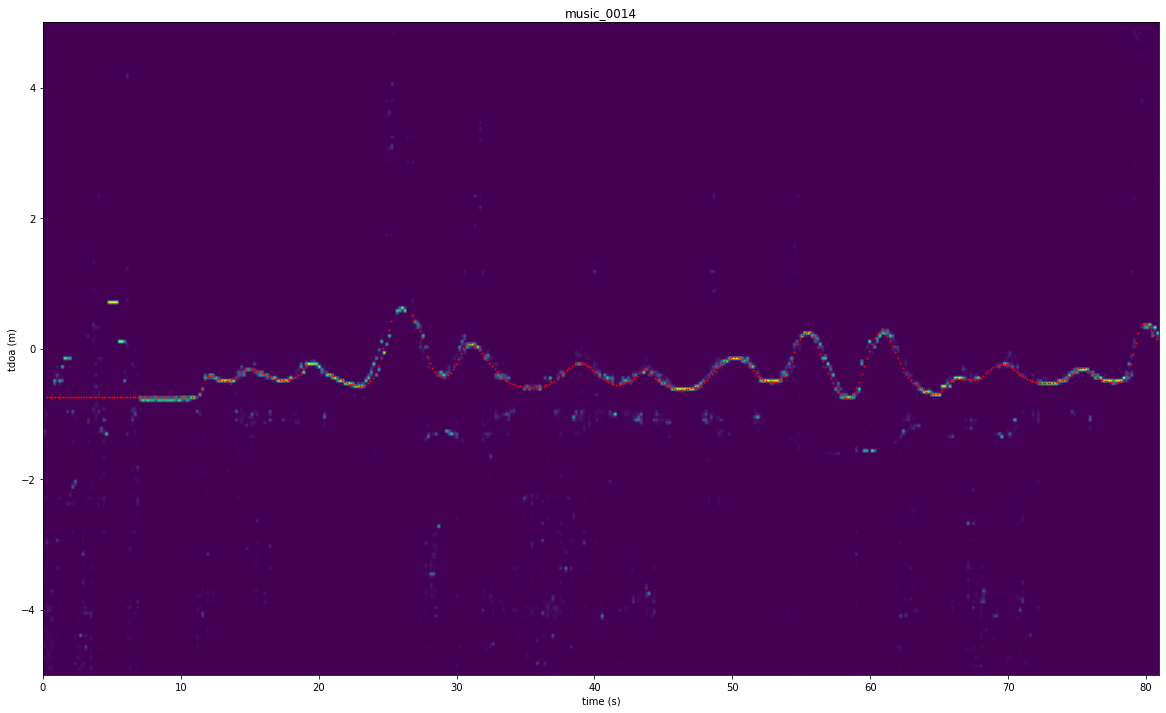

In [116]:
# plt.figure(figsize=(20,12))
# plt.imshow(pred.softmax(dim=1).detach().T, aspect='auto')
# plt.plot(y,'r.',markersize=2)
samples_per_class = 2*config["max_shift"]/config["guess_grid_size"]
edge_time_difference = (samples_per_class*config["guess_grid_size"]//2)*speed_of_sound/16000

plt.figure(figsize=(20,12))
plt.imshow(pred.softmax(dim=1).detach().T, aspect='auto', extent=[0, 2*chunk_times[-1] - chunk_times[-2],-edge_time_difference,edge_time_difference])
plt.plot(chunk_times,-pairs_gt[pair_i],'r.',markersize=2)
plt.ylim(-5,5)
plt.ylabel("tdoa (m)")
plt.xlabel("time (s)")
plt.title(experiment)